# 1. Extraction, general checking, and pre-processing

Here we use several datasets: <br>
1.HUNT3 dataset, containing the variables from the questionnaires <br>
2.HUNT3 metabolomics dataset <br>
3.Pre-defined diseases datasets, containing labels for psoriasis cases, cutaneous-activity, and severity; as well as other IMIDs  <br>
4.Prescription registry (LMR) dataset, to define the medication use <br>

## 1.1. General data checking and cleaning

### 1.1.1. Loading HUNT3 datasets

In [1]:
# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Import basic libraries
import pandas as pd
import numpy as np

# Import the HUNT3 dataset
hunt = pd.read_spss('/mnt/archive/phenotypes/hunt/2020-05-19_Datautlevering_106337/2020-05-13_106337_minus_troponin_Data.sav')

# Extract dataset to necessary columns only
cols_to_extract = ['PID@106337', # participants IDs
                    'Sex',
                    'PartAg@NT3BLQ1', # age
                    'BMI@NT3BLM', # BMI
                    'TmLMe@NT3BLM', # fasting time
                    'SmoStat@NT3BLQ1', # smoking status(https://hunt-db.medisin.ntnu.no/hunt-db/variable/1111615)
                    'PartDat@NT3BLQ1', # participation date for HUNT3
                  ]

hunt = hunt[cols_to_extract]

# Rename the columns
col_names = ['PID',
             'sex',
             'age',
             'bmi',
             'fast',
             'smo',
             'pdat',
             ]

hunt.columns = col_names

# Slice data to include only HUNT3 participants
hunt = hunt[pd.notnull(hunt['pdat'])]
print(f'number of HUNT3 participants: {len(hunt)}')

number of HUNT3 participants: 50815


In [2]:
# Import the imputed metabolomics dataset
met = pd.read_csv('imputed_metabolomics.csv')

# Uncomment to see the unimputed metabolomics data
#met = pd.read_csv('/mnt/archive/phenotypes/hunt/2024-09-04_metabolomics_106337/HUNT3_metabolomics_adjusted_106337_pointdecimal.txt', sep = '\t')

# Remove the duplicated PIDs from batch 2
duplicate_mask = met.duplicated('PID.106337', keep=False)

met = met[
    (~duplicate_mask) |  # keep unique PIDs
    ((duplicate_mask) & (met['Batch'] == 1))  # keep duplicates where batch == 1
]

### 1.1.2. Converting categorical values

In [3]:
# Define function to convert values based on a dictionary
def convcod(lst, dic):
    update = list((pd.Series(lst)).map(dic))
    return update

# Dictionary of sex codes
sex_codes = {'Kvinne': int(0), 'Mann': int(1)}

# Dictionary of smoking status codes
smo_codes = {'Aldri røykt': int(0),
             'Tidligere røyker': int(1),
             'Daglig røyker': int(2),
             'Røyker av og til': int(2)
             }

hunt['sex'] = convcod(hunt['sex'], sex_codes)
hunt['smo'] = convcod(hunt['smo'], smo_codes)

print(hunt['sex'].dtype)
print(hunt['smo'].dtype) # Return float because the column contains NaNs

int64
float64


### 1.1.3. Changing data types

In [4]:
# Change PID data type from object to integer
hunt['PID'] = hunt['PID'].astype(str).astype(int)

# Remove time from the participation date and convert data type to datetime
hunt['pdat'] = pd.to_datetime(hunt['pdat']).dt.date
hunt['pdat'] = pd.to_datetime(hunt['pdat'])

# Change smoking data type to categorical
hunt['smo'] = hunt['smo'].astype('Int64') # Int64 to be able to store NaNs

### 1.1.4. Defining lipid lowering medication use

In [5]:
# Import the prescription registry dataset
lmr = pd.read_csv('/mnt/archive/phenotypes/lmr/69_141_uttrekksfil_2023-10-09T13.37.31.csv', sep = ';', on_bad_lines='skip')

# Slice data into those using lipid modifying medications (ATC code C10)
lmr = lmr[lmr['Legemiddel_ATCkode_Niva5'].str.startswith('C10')]

# Merge the LMR dataset with HUNT participation date
hunt['PID'] = hunt['PID'].astype(str).astype(int)
lmr = lmr.merge(hunt[['PID', 'pdat']], left_on='PID@106337', right_on= 'PID', how='left')

# Convert data type to date time
lmr['pdat'] = pd.to_datetime(lmr['pdat'])
lmr['Utlevering_Dato'] = pd.to_datetime(lmr['Utlevering_Dato'])

# Assign 1 if any prescription discharged within 3 months to the participation date, else 0
lmr['meds'] = ((lmr['pdat'] - lmr['Utlevering_Dato']).dt.days.between(1, 365)).astype(int)

# Get the unique PIDs that were prescribed with C10 medications within 12 months
c10_pid = lmr['PID@106337'][lmr['meds'] == 1].unique()

# Create new column in HUNT dataset, fill 1 if PIDs identified with C10 medicatios, else 0
hunt['meds'] = hunt['PID'].isin(c10_pid).astype(int)

# Check results
print(hunt['meds'].value_counts())

meds
0    44103
1     6712
Name: count, dtype: int64


### 1.1.5. Defining diseases

In [6]:
# Import the psoriasis outcome datasets
pso = pd.read_csv('/mnt/archive/phenotypes/custom/metabo/HUNT_HNT_KUHR_LMR_PSO-Metabo_2025-02-21.tsv', sep = '\t')
pso_sev = pd.read_csv('/mnt/archive/phenotypes/custom/metabo/HUNT_HNT_KUHR_LMR_PSO-Metabo_2025-10-15.tsv', sep = '\t')
pso_act = pd.read_csv('/mnt/archive/phenotypes/custom/metabo/HUNT_HNT_KUHR_LMR_PsoActive2W-Metabo_2025-09-15.tsv', sep = '\t')

print(len(pso))
print(len(pso_act))
print(len(pso_sev))

16924
16924
16924


In [7]:
# Merge psoriasis outcome datasets
pso = pso.merge(pso_act[['PID', 'ActivePsor2W', 'ActivePsor2W_Age', 'ActivePsor2W_Date']], on = 'PID',how = 'inner')

# Create a new variable for prevalent psoriasis
pso['pso'] = np.where(pso['Psor'] < 1, int(0), int(1))

# Create a new variable for prevalent active psoriasis vs non-psoriasis
pso['act'] = np.nan

pso.loc[(pso['pso'] == 1) & (pso_act['ActivePsor2W'] == 1), 'act'] = int(1)
pso.loc[(pso['pso'] == 1) & (pso_act['ActivePsor2W'] == 0), 'act'] = np.nan
pso.loc[pso['pso'] == 0, 'act'] = int(0)

# Create a new variable for prevalent non-active psoriasis vs non-psoriasis
pso['non_act'] = np.nan

pso.loc[(pso['pso'] == 1) & (pso_act['ActivePsor2W'] == 1), 'non_act'] = np.nan
pso.loc[(pso['pso'] == 1) & (pso_act['ActivePsor2W'] == 0), 'non_act'] = int(1)
pso.loc[pso['pso'] == 0, 'non_act'] = int(0)

# Create a new variable for prevalent active vs non-active psoriasis 
pso['act_non_act'] = np.nan

pso.loc[(pso['pso'] == 1) & (pso_act['ActivePsor2W'] == 1), 'act_non_act'] = int(1)
pso.loc[(pso['pso'] == 1) & (pso_act['ActivePsor2W'] == 0), 'act_non_act'] = int(0)
pso.loc[pso['pso'] == 0, 'act_non_act'] = np.nan

# Create a new variable for severe prevalent psoriasis vs non-psoriasis
pso['sev'] = np.nan

pso.loc[(pso['pso'] == 1) & (pso_sev['PsorSevL1Y'] == 1), 'sev'] = int(1)
pso.loc[(pso['pso'] == 1) & (pso_sev['PsorSevL1Y'] == 0), 'sev'] = np.nan
pso.loc[(pso['pso'] == 0), 'sev'] = int(0)

# Create a new variable for non-severe prevalent psoriasis vs non-psoriasis
pso['non_sev'] = np.nan

pso.loc[(pso['pso'] == 1) & (pso_sev['PsorSevL1Y'] == 1), 'non_sev'] = np.nan
pso.loc[(pso['pso'] == 1) & (pso_sev['PsorSevL1Y'] == 0), 'non_sev'] = int(1)
pso.loc[(pso['pso'] == 0), 'non_sev'] = int(0)

# Create a new variable for severe vs non-severe prevalent psoriasis
pso['sev_non_sev'] = np.nan

pso.loc[(pso['pso'] == 1) & (pso_sev['PsorSevL1Y'] == 1), 'sev_non_sev'] = int(1)
pso.loc[(pso['pso'] == 1) & (pso_sev['PsorSevL1Y'] == 0), 'sev_non_sev'] = int(0)
pso.loc[(pso['pso'] == 0), 'sev_non_sev'] = np.nan

# Merge HUNT and pso dataset
hunt = hunt.merge(pso, on = 'PID', how = 'inner')

# Check numbers of cases
print(f'number of prevalent psoriasis cases:')
print(hunt['pso'].value_counts())
print(f'number of prevalent active psoriasis cases:')
print(hunt['act'].value_counts())
print(f'number of prevalent severe psoriasis cases:')
print(hunt['sev'].value_counts())

number of prevalent psoriasis cases:
pso
0    15899
1     1025
Name: count, dtype: int64
number of prevalent active psoriasis cases:
act
0.0    15899
1.0      455
Name: count, dtype: int64
number of prevalent severe psoriasis cases:
sev
0.0    15899
1.0       72
Name: count, dtype: int64


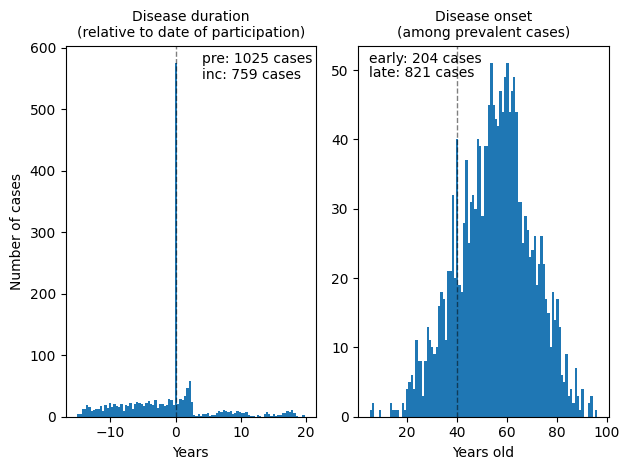

In [8]:
# Calculate disease duration (unit in year)
duration = (pd.to_datetime(pso['H3Date']) - pd.to_datetime(pso['Psor_Date'])) / pd.Timedelta(days = 365) 
pso['pso_dur'] = duration

# Calculate number of prevalent and incident cases
incident = sum(x < 0 for x in pso['pso_dur'])
prevalent = sum(x >= 0 for x in pso['pso_dur'])

# Calculate number of early and late onset in prevalent cases
early = sum(x < 40 for x in pso[pso['Psor'] == 1]['Psor_Age'])
late = sum(x >= 40 for x in pso[pso['Psor'] == 1]['Psor_Age'])

# Check the distribution of disease duration and onset
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(pso['pso_dur'], bins=100)
axs[0].set_xlabel('Years')
axs[0].set_ylabel('Number of cases')
axs[0].set_title('Disease duration\n(relative to date of participation)',fontsize=10)
axs[0].axvline(0, color='black', linestyle='--', alpha = 0.5, lw = 1)
axs[0].text(4, 575, f'pre: {prevalent} cases')
axs[0].text(4, 550, f'inc: {incident} cases')

    
axs[1].hist(pso['Psor_Age'], bins=100)
axs[1].set_xlabel('Years old')
axs[1].set_title('Disease onset\n(among prevalent cases)',fontsize=10)
axs[1].axvline(40, color='black', linestyle='--', alpha = 0.5, lw = 1)
axs[1].text(5, 51, f'early: {early} cases')
axs[1].text(5, 49, f'late: {late} cases')

plt.savefig('disease duration and onset.pdf')

In [9]:
# Importing validated rheumatology data
rheu = pd.read_csv("/mnt/archive/phenotypes/custom/metabo/HUNT_HNT_KUHR_LMR_Rheuma-Metabo_2025-04-22.tsv", sep = '\t')

# Create new variables for prevalent RA, SpA, PsA
rheu['ra'] = np.where(rheu['RA'] < 1, int(0), int(1))
rheu['spa'] = np.where(rheu['AS'] < 1, int(0), int(1))
rheu['pre_psa'] = np.where(rheu['PSA'] < 1, int(0), int(1))

# Importing other IMIDs
ibd = pd.read_csv("/mnt/archive/phenotypes/custom/metabo/HUNT_HNT_KUHR_LMR_IBD-Metabo_2025-03-20.tsv", sep = '\t')
sle = pd.read_csv("/mnt/archive/phenotypes/custom/metabo/HUNT_HNT_KUHR_LMR_Sle-Metabo_2025-03-20.tsv", sep = '\t')
ecz = pd.read_csv("/mnt/archive/phenotypes/custom/metabo/HUNT_HNT_KUHR_LMR_Ecz-Metabo_2025-03-03.tsv", sep = '\t')

# Create new variables for prevalent UC, CD, SLE, and AD
ibd['uc'] = np.where(ibd['Uc'] < 1, int(0), int(1))
ibd['cd'] = np.where(ibd['Cd'] < 1, int(0), int(1))
sle['sle'] = np.where(sle['Sle'] < 1, int(0), int(1))
ecz['ad'] = np.where(ecz['Ecz'] < 1, int(0), int(1))

# Merge with HUNT dataset
hunt = hunt.merge(rheu[['PID', 'ra', 'spa', 'pre_psa']], on = 'PID', how = 'inner')
hunt = hunt.merge(ibd[['PID', 'uc', 'cd']], on = 'PID', how = 'inner')
hunt = hunt.merge(sle[['PID', 'sle']], on = 'PID', how = 'inner')
hunt = hunt.merge(ecz[['PID', 'ad']], on = 'PID', how = 'inner')

# Create a new variable for psoriatic arthritis vs non-psoriatic arthritis
hunt['psa_non_psa'] = np.nan

hunt.loc[(hunt['pso'] == 1) & (hunt['pre_psa'] == 1), 'psa_non_psa'] = int(1)
hunt.loc[(hunt['pso'] == 1) & (hunt['pre_psa'] == 0), 'psa_non_psa'] = int(0)
hunt.loc[hunt['pso'] == 0, 'psa_non_psa'] = np.nan

# Create a new variable for psoriatic arthritis vs non-psoriasis
hunt['psa'] = np.nan

hunt.loc[(hunt['pso'] == 1) & (hunt['pre_psa'] == 1), 'psa'] = int(1)
hunt.loc[(hunt['pso'] == 1) & (hunt['pre_psa'] == 0), 'psa'] = np.nan
hunt.loc[hunt['pso'] == 0, 'psa'] = int(0)

# Create a new variable for non-psoriatic arthritis vs non-psoriasis
hunt['non_psa'] = np.nan

hunt.loc[(hunt['pso'] == 1) & (hunt['pre_psa'] == 1), 'non_psa'] = np.nan
hunt.loc[(hunt['pso'] == 1) & (hunt['pre_psa'] == 0), 'non_psa'] = int(1)
hunt.loc[hunt['pso'] == 0, 'non_psa'] = int(0)

# Check numbers of cases
print(f'number of prevalent ra cases:')
print(hunt['ra'].value_counts())
print(f'number of prevalent spa cases:')
print(hunt['spa'].value_counts())
print(f'number of prevalent psa cases:')
print(hunt['psa_non_psa'].value_counts()) # among psoriasis cases, 0: non psa, 1: psa
print(f'number of prevalent uc cases:')
print(hunt['uc'].value_counts())
print(f'number of prevalent cd cases:')
print(hunt['cd'].value_counts())
print(f'number of prevalent sle cases:')
print(hunt['sle'].value_counts())
print(f'number of prevalent ad cases:')
print(hunt['ad'].value_counts())

number of prevalent ra cases:
ra
0    16808
1      116
Name: count, dtype: int64
number of prevalent spa cases:
spa
0    16885
1       39
Name: count, dtype: int64
number of prevalent psa cases:
psa_non_psa
0.0    914
1.0    111
Name: count, dtype: int64
number of prevalent uc cases:
uc
0    16661
1      263
Name: count, dtype: int64
number of prevalent cd cases:
cd
0    16830
1       94
Name: count, dtype: int64
number of prevalent sle cases:
sle
0    16876
1       48
Name: count, dtype: int64
number of prevalent ad cases:
ad
0    14891
1     2033
Name: count, dtype: int64


## 1.4. Imputation of covariates

### 1.4.1. Preparing and checking dataset

In [10]:
# Prepare the dataset
id_covariates = ['PID', 'sex', 'age', 'bmi', 'smo', 'meds'] # ID and covariates

to_impute = hunt[id_covariates].merge(met, left_on = 'PID',
                                        right_on = 'PID.106337',
                                        how = 'inner')

# Check missingness
print('proportion of missing values (%):')
print(to_impute[id_covariates].isnull().sum() * 100 / len(to_impute))

# Drop PID (not needed / do not contain any information for the imputation)
to_impute = to_impute.drop(columns=['PID'])

proportion of missing values (%):
PID     0.000000
sex     0.000000
age     0.000000
bmi     0.330891
smo     2.534862
meds    0.000000
dtype: float64


<Axes: >

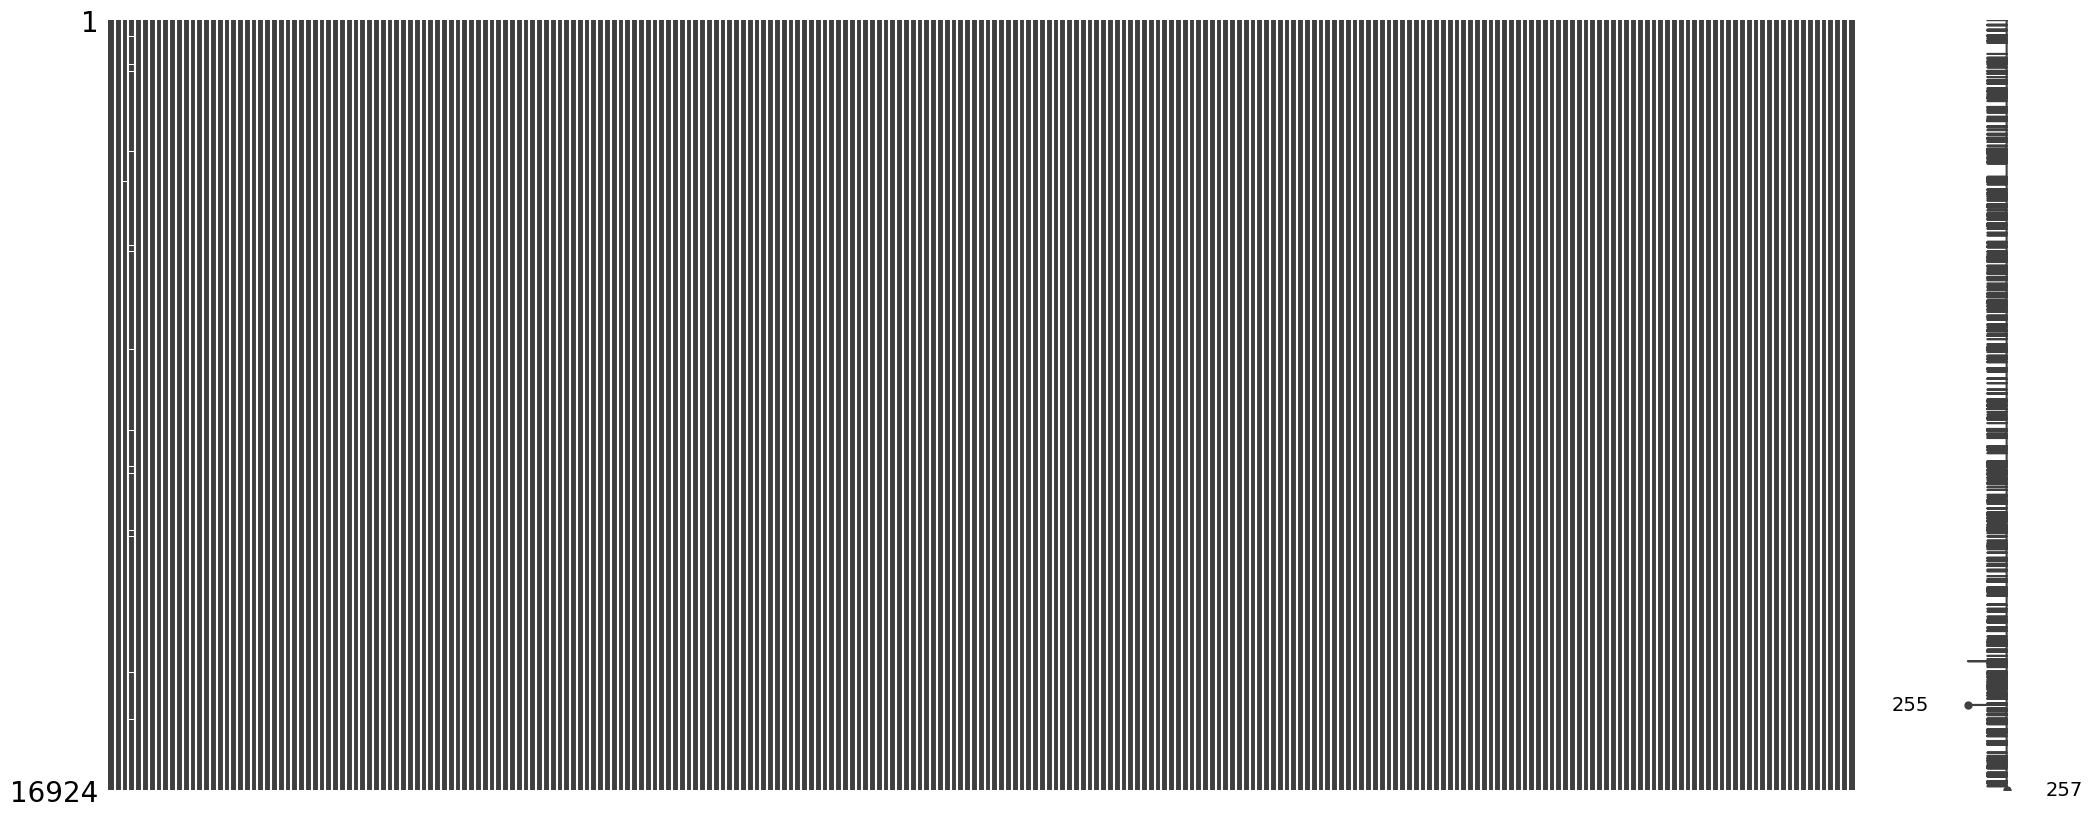

In [11]:
# Check the missingness visually
import missingno as msno

msno.matrix(to_impute)

### 1.4.2. Performing imputation

In [12]:
# Impute dataset
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
    
imputer = IterativeImputer(random_state=0, max_iter = 5)
imputed = imputer.fit_transform(to_impute)
imputed_df = pd.DataFrame(imputed, columns = to_impute.columns)

<Axes: >

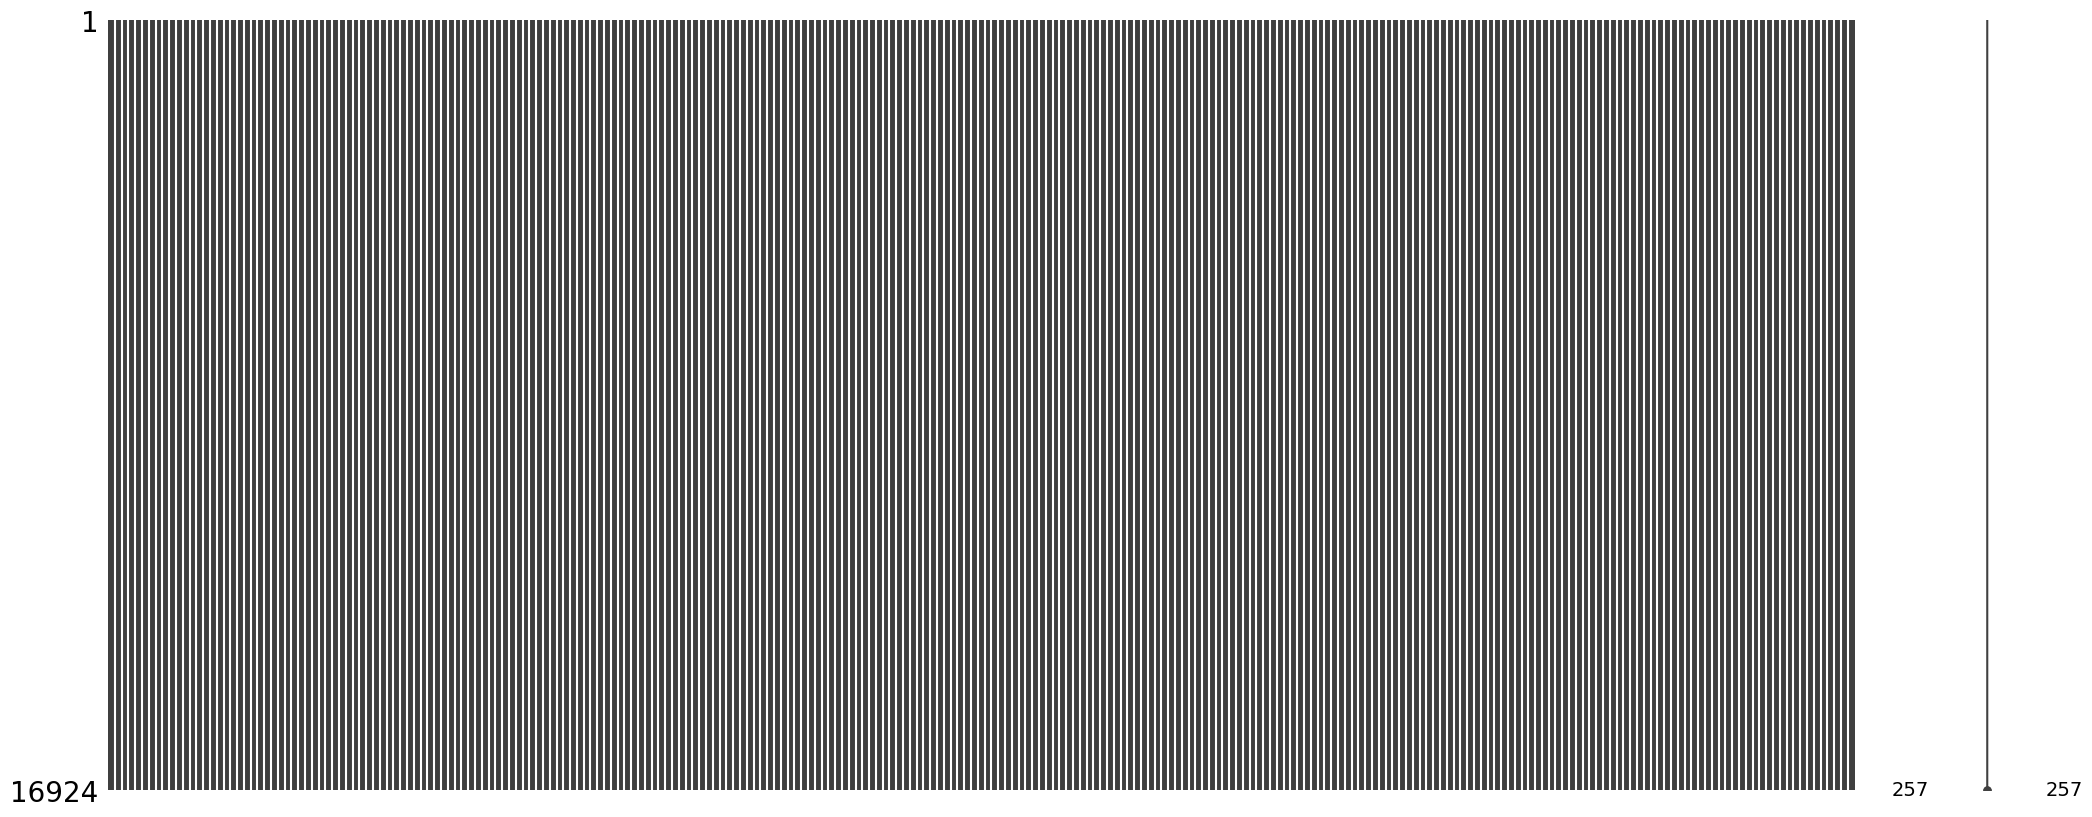

In [13]:
# Check the imputation result visually
msno.matrix(imputed_df)

In [14]:
# Check the imputation result
print('proportion of missing values (%):')
print(imputed_df[['bmi', 'smo']].isnull().sum() * 100 / len(imputed_df))

proportion of missing values (%):
bmi    0.0
smo    0.0
dtype: float64


In [15]:
# Returning imputed columns to the original HUNT3 dataset
hunt[['bmi', 'smo']] = imputed_df[['bmi', 'smo']]

# Changing data types for smo (the imputation changes the datatype into float)
hunt['smo'] = hunt['smo'].astype('int64').astype('category')

# Check the transfer
print('proportion of missing values (%):')
print(hunt[['bmi', 'smo']].isnull().sum() * 100 / len(hunt))
print(len(hunt), len(imputed_df))

proportion of missing values (%):
bmi    0.0
smo    0.0
dtype: float64
16924 16924


### 1.4.3. Evaluating imputation

In [16]:
# Define function to evaluate the imputation
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

def compare_imputed_vs_original(original_df, imputed_df, columns, var_type='continuous', pdf_filename='comparison_plots.pdf'):
    with PdfPages(pdf_filename) as pdf:
        for col in columns:
            plt.figure(figsize=(6, 4))
            
            if var_type == 'continuous':
                sns.kdeplot(original_df[col].dropna(), label='Original (non-missing)', fill=True)
                sns.kdeplot(imputed_df[col], label='Imputed', fill=True)
                plt.title(f'Distribution for {col}')
            
            elif var_type == 'categorical':
                orig_counts = original_df[col].dropna().value_counts(normalize=True)
                imp_counts = imputed_df[col].value_counts(normalize=True)
                compare_df = pd.DataFrame({'Original': orig_counts, 'Imputed': imp_counts}).fillna(0)
                compare_df.plot(kind='bar', ax=plt.gca())
                plt.title(f'Category distribution for {col}')
                plt.ylabel('Proportion')
            
            plt.legend()
            plt.tight_layout()
            pdf.savefig() 
            plt.close()

compare_imputed_vs_original(original_df=to_impute,
                            imputed_df=hunt,
                            columns=['bmi'],
                            var_type='continuous',
                            pdf_filename='imputation - bmi.pdf'
                           )

compare_imputed_vs_original(original_df=to_impute,
                            imputed_df=hunt,
                            columns=['smo'],
                            var_type='categorical',
                            pdf_filename='imputation - smo.pdf'
                           )

## 1.3. Metabolomics dataset checking and pre-processing

### 1.3.1. General check

In [17]:
# Check the distribution of the metabolites

# Get the metabolite names
met_names = met.columns[2:]

# Function to apply the KS test on a single column
import math
from scipy.stats import kstest

def ks_pvalue(col):
    return kstest(col, 'norm').pvalue


# Create a histogram for visual inspection
import matplotlib.pyplot as plt

def create_histogram(title, data):
    # Define number of histograms per page 
    histograms_per_page = 20
    columns_per_page = 4  
    rows_per_page = 5 

    # Create a PDF to save all the histograms
    from matplotlib.backends.backend_pdf import PdfPages
    pdf_pages = PdfPages(f'{title} - histogram.pdf')

    # Plot the metabolites in loop
    for start in range(0, len(data.columns), histograms_per_page):
        fig, axes = plt.subplots(nrows=columns_per_page, ncols=rows_per_page, figsize=(8.27, 11.69))  # A4 size
        axes = axes.flatten()  # Flatten the 2D array of axes to make it easier to iterate over

        for i, col in enumerate(data.columns[start:start + histograms_per_page]):
            if i >= len(axes):
                break  # Prevent exceeding available axes
            axes[i].hist(data[col], bins=100, color='skyblue')
            axes[i].set_title(col, fontsize=8)  

        plt.tight_layout()
        pdf_pages.savefig(fig) 
        plt.close(fig)  
    pdf_pages.close()

In [18]:
# Apply the function to all continuous columns
met_pvalues = met[met_names].apply(ks_pvalue)

# if p-value < 0.05, sufficient evidence that the data does not come from a normal distribution
# Check for any columns having p-value > 0.05 (normally distributed)
print('normally distributed metabolites:')
print(met_pvalues[met_pvalues > 0.05])

# Call the function to create histogram
create_histogram(title='original_data', data=met[met_names])

normally distributed metabolites:
Series([], dtype: float64)


### 1.3.2. Remove outliers

In [19]:
# Define function to calculate the lower and upper bounds
def calculate_outlier_bounds(data, col, multiplier=4):
    """
    Calculate the outlier bounds for a given column using the IQR method.
    Returns lower and upper bounds for outlier detection.
    """
    # Calculate Q1, Q3, and IQR for the column
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1

    # Determine the lower and upper bounds for outliers
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    return lower_bound, upper_bound

# Function to create box plots and mark outliers
from matplotlib.backends.backend_pdf import PdfPages

def create_box_plots(title, data, multiplier=4):
    # Create a PDF to save all the box plots
    pdf_pages = PdfPages(f'{title} - box plot.pdf')
    
    # Loop through the columns in chunks
    for start in range(0, len(data.columns), 20):
        # Create a new figure for each set of box plots (4 rows, 5 columns per page)
        fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(8.27, 11.69))  # A4 size
        axes = axes.flatten()  # Flatten the 2D array of axes to make it easier to iterate over

        # Loop over the columns and create a box plot for each one
        for i, col in enumerate(data.columns[start:start + 20]):
            if i >= len(axes):
                break  # Prevent exceeding available axes
            
            lower_bound, upper_bound = calculate_outlier_bounds(data, col, multiplier)
            
            # Create the box plot
            axes[i].boxplot(data[col].dropna(), showfliers=False)
            axes[i].set_title(col, fontsize=8)  # Set the title to the column name (variable)
            
            # Highlight the outliers (values outside the IQR bounds)
            outliers = data[col][(data[col] < lower_bound) | (data[col] > upper_bound)]
            axes[i].scatter(np.ones(len(outliers)) * 1, outliers, color='red')  # Red dots for outliers
            
            # Display the number of outliers in the upper-right corner of the plot
            outlier_count = len(outliers)
            axes[i].text(0.95, 0.95, f'{outlier_count}', 
                         horizontalalignment='right', verticalalignment='top',
                         transform=axes[i].transAxes, fontsize=8, color='red')
            
            axes[i].set_xticklabels([])  # Remove x-tick labels

        # Adjust layout to prevent overlap and save this figure as a new page in the PDF
        plt.tight_layout()
        pdf_pages.savefig(fig)  # Save current figure to the PDF
        plt.close(fig)  # Close the figure to avoid memory issues

    # Close the PDF file after saving all pages
    pdf_pages.close()
    
# Define a function to remove outliers based on the 4 * IQR rule, and fill in values with the lower / upper bounds
def remove_outliers(df, multiplier=4):
    # Copying the original data to avoid modifying it directly
    df_cleaned = df.copy()
    
    for col in df.columns:
        # Calculate the lower and upper bounds for outliers
        lower_bound, upper_bound = calculate_outlier_bounds(df, col, multiplier)
        
        # Identify non-outlier data
        data = df[col]
        cleaned_data = data[(data >= lower_bound) & (data <= upper_bound)]

        # Get min and max of cleaned data
        min_valid = cleaned_data.min()
        max_valid = cleaned_data.max()

        # Replace outliers
        data_clipped = data.copy()
        data_clipped[data > upper_bound] = max_valid
        data_clipped[data < lower_bound] = min_valid
        
        df_cleaned[col] = data_clipped
    
    return df_cleaned

In [20]:
# Create boxplots to visualize outliers
create_box_plots('outliers', met[met_names], multiplier=4)

# Apply outlier removal
df_no_outliers = remove_outliers(met[met_names], multiplier=4)

# Create histograms to visualize the cleaned data
create_histogram(title='cleaned', data=df_no_outliers)

### 1.3.3. Log1p transformation

In [21]:
# Apply log1p transformation
df_cleaned_transformed = df_no_outliers.apply(np.log1p)
df_uncleaned_transformed = met[met_names].apply(np.log1p)

# Create histograms to visualize the transformed data
create_histogram(title='cleaned_transformed', data=df_cleaned_transformed)
create_histogram(title='uncleaned_transformed', data=df_uncleaned_transformed)

### 1.3.4. Scaling (z transformation)

In [22]:
# Transform values into z-score
import scipy.stats as stats

df_scaled = met[met_names].apply(stats.zscore, nan_policy='omit') # original data with outliers
df_cleaned_scaled = df_no_outliers.apply(stats.zscore, nan_policy='omit') # data without outliers
df_cleaned_transformed_scaled = df_cleaned_transformed.apply(stats.zscore, nan_policy='omit') # transformed data without outliers
df_uncleaned_transformed_scaled = df_uncleaned_transformed.apply(stats.zscore, nan_policy='omit') # transformed data with outliers

In [23]:
# Define function to create a KDE plot visualizing the four pre-processing approaches
from scipy.stats import gaussian_kde

def create_overlay_4kde(title, data_list, labels=None, colors=None):
    histograms_per_page = 20
    columns_per_page = 4  
    rows_per_page = 5 

    if labels is None:
        labels = [f'Dataset {i+1}' for i in range(len(data_list))]
    if colors is None:
        colors = ['skyblue', 'salmon', 'green', 'orange']

    pdf_pages = PdfPages(f'{title} - kde.pdf')

    for start in range(0, len(data_list[0].columns), histograms_per_page):
        fig, axes = plt.subplots(nrows=rows_per_page, ncols=columns_per_page, figsize=(8.27, 11.69))
        axes = axes.flatten()

        for i, col in enumerate(data_list[0].columns[start:start + histograms_per_page]):
            ax = axes[i]

            x_min, x_max = np.inf, -np.inf  # To sync x-limits across datasets in each subplot

            for d_idx, data in enumerate(data_list):
                d = data[col].dropna()
                if len(d) >= 2:
                    kde = gaussian_kde(d)
                    x = np.linspace(d.min(), d.max(), 100)
                    x_min, x_max = min(x_min, d.min()), max(x_max, d.max())
                    ax.plot(x, kde(x), label=labels[d_idx], color=colors[d_idx], alpha=0.4)
            
            ax.set_title(col, fontsize=8)
            ax.grid(True, linestyle='--', linewidth=0.5)
            ax.tick_params(labelsize=6)
            ax.legend(fontsize=5, loc='upper right')

        # Hide unused axes
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        plt.tight_layout()
        pdf_pages.savefig(fig)
        plt.close(fig)
    
    pdf_pages.close()
    
# Create the overlay KDE plot
create_overlay_4kde(
    title='preprocessing comparison',
    data_list=[df_scaled, df_cleaned_scaled, df_uncleaned_transformed_scaled, df_cleaned_transformed_scaled],
    labels=['uncleaned', 'cleaned only', 'transformed only', 'cleaned & transformed'],
    colors=['skyblue', 'salmon', 'green', 'purple']
)

# 2. Association analysis

In [24]:
# Merging the results of different pre-processing steps
met_df = pd.concat([met['PID.106337'], 
                    #df_scaled.add_suffix('_sc'),
                    #df_cleaned_scaled.add_suffix('_clsc'),
                    #df_uncleaned_transformed_scaled.add_suffix('_uctrsc'),
                    df_cleaned_transformed_scaled.add_suffix('_cltrsc')], axis=1)

# Preparing the dataset, merging the metabolomics data to HUNT3 and psoriasis definitions
cols_to_extract = ['PID',
                   'age', 'sex', 'bmi', 'smo', 'meds', # Covariates
                   'fast',
                   'pso', 'ra', 'spa', 'uc', 'cd', 'sle', 'ad', #IMIDs
                   'sev', 'non_sev', 'sev_non_sev', # Severity
                   'act', 'non_act', 'act_non_act', # Activity
                   'psa', 'non_psa', 'psa_non_psa', # Psoriatic arthritis
                  ]
                   
                   
baseline_df = hunt[cols_to_extract].merge(met_df,
                         left_on = 'PID',
                         right_on = 'PID.106337',
                         how = 'inner'
                        )

In [25]:
# Check data types for each column
def check_dtype(data):
    int_dtype = []
    flo_dtype = []
    cat_dtype = []
    oth_dtype = []

    for column, dtype in data.dtypes.items():
        if dtype == 'int64':
            int_dtype.append(column)
        elif dtype == 'float64':
            flo_dtype.append(column)
        elif dtype == 'category':
            cat_dtype.append(column)
        else:
            oth_dtype.append(column)

    return int_dtype, flo_dtype, cat_dtype, oth_dtype

int_dtype, flo_dtype, cat_dtype, oth_dtype = check_dtype(baseline_df)

print(f"Columns with integer data type: {int_dtype}")
print(f"Columns with float data type: {flo_dtype}")
print(f"Columns with categorical data type: {cat_dtype}")
print(f"Columns with other data type: {oth_dtype}")

Columns with integer data type: ['PID', 'sex', 'meds', 'pso', 'ra', 'spa', 'uc', 'cd', 'sle', 'ad', 'PID.106337']
Columns with float data type: ['age', 'bmi', 'fast', 'sev', 'non_sev', 'sev_non_sev', 'act', 'non_act', 'act_non_act', 'psa', 'non_psa', 'psa_non_psa', 'Total_C_cltrsc', 'non_HDL_C_cltrsc', 'Remnant_C_cltrsc', 'VLDL_C_cltrsc', 'Clinical_LDL_C_cltrsc', 'LDL_C_cltrsc', 'HDL_C_cltrsc', 'Total_TG_cltrsc', 'VLDL_TG_cltrsc', 'LDL_TG_cltrsc', 'HDL_TG_cltrsc', 'Total_PL_cltrsc', 'VLDL_PL_cltrsc', 'LDL_PL_cltrsc', 'HDL_PL_cltrsc', 'Total_CE_cltrsc', 'VLDL_CE_cltrsc', 'LDL_CE_cltrsc', 'HDL_CE_cltrsc', 'Total_FC_cltrsc', 'VLDL_FC_cltrsc', 'LDL_FC_cltrsc', 'HDL_FC_cltrsc', 'Total_L_cltrsc', 'VLDL_L_cltrsc', 'LDL_L_cltrsc', 'HDL_L_cltrsc', 'Total_P_cltrsc', 'VLDL_P_cltrsc', 'LDL_P_cltrsc', 'HDL_P_cltrsc', 'VLDL_size_cltrsc', 'LDL_size_cltrsc', 'HDL_size_cltrsc', 'Phosphoglyc_cltrsc', 'TG_by_PG_cltrsc', 'Cholines_cltrsc', 'Phosphatidylc_cltrsc', 'Sphingomyelins_cltrsc', 'ApoB_cltrsc', 'A

In [26]:
# # If needed: change data types for columns with wrong data types
# # Define the conversion dictionary
# convert_dict = {
#     # Integers
#     'age': 'int64', 'sex': 'int64', 'meds': 'int64', 'pso': 'int64', 'ad': 'int64', 'sle': 'int64',
#     'ra': 'int64', 'cd': 'int64', 'uc': 'int64', 'spa': 'int64', 'ra': 'int64', 
    
#     # Float (to contain NaNs)
#     'psa_non_psa': 'float64', 'psa': 'float64', 'non_psa': 'float64',
#     'sev_non_sev': 'float64', 'sev': 'float64', 'non_sev': 'float64',
    
#     # Category
#     'smo': 'category'
# }



# # Convert columns using the dictionary
# baseline_df = baseline_df.astype(convert_dict)

# # Check results
# int_dtype, flo_dtype, cat_dtype, oth_dtype = check_dtype(baseline_df)

# print(f"Columns with integer data type: {int_dtype}")
# print(f"Columns with float data type: {flo_dtype}")
# print(f"Columns with categorical data type: {cat_dtype}")
# print(f"Columns with other data type: {oth_dtype}")

## 2.1. Diagnostics

In [28]:
# Define function to perform diagnostics to check the assumptions of linear regression
from scipy.stats import shapiro, probplot
from statsmodels.stats.diagnostic import het_breuschpagan

def model_diagnostics(result, outcome, model, df_type, met):
    """
    Plot diagnostic plots and perform tests for a linear regression model.
    """
    
    # Shapiro-Wilk Test for Normality
    stat, p_value = shapiro(result.resid)
    sw_p = round(p_value, 4)
    
    # Breusch-Pagan Test for Homoscedasticity
    bp_test = het_breuschpagan(result.resid, result.model.exog)
    bp_p = round(bp_test[1], 4)

    # Residuals vs Fitted Plot
    plt.figure(figsize=(6, 4))
    sns.residplot(x=result.fittedvalues, y=result.resid, lowess=False, 
                  line_kws={'color': 'red'})
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs Fitted\n{outcome}, model {model}, {df_type}, {met}')
    plt.text(.05, .95, f'BP p-value = {bp_p}', ha='left', va='top', transform=plt.gca().transAxes)
    plt.savefig(f'[{outcome}, {model}, {df_type}, {met}] - Residuals vs Fitted.pdf')
    plt.show()
    
    # Q-Q Plot for Normality
    plt.figure(figsize=(6, 4))
    probplot(result.resid, dist="norm", plot=plt)
    plt.title(f'Normal Q-Q Plot\n{outcome}, model {model}, {df_type}, {met}')
    plt.text(.05, .95, f'SW p-value = {sw_p}', ha='left', va='top', transform=plt.gca().transAxes)
    plt.savefig(f'[{outcome}, {model}, {df_type}, {met}] - Normal Q-Q Plot.pdf')
    plt.show()
                
    # Histogram of Residuals
    plt.figure(figsize=(6, 4))
    sns.histplot(result.resid, bins=20, kde=True)
    plt.title(f'Histogram of Residuals\n{outcome}, model {model}, {df_type}, {met}')
    plt.text(.05, .95, f'SW p-value = {sw_p}', ha='left', va='top', transform=plt.gca().transAxes)
    plt.savefig(f'[{outcome}, {model}, {df_type}, {met}] - Histogram of Residuals.pdf')
    plt.show()

## 2.2. Regression

In [29]:
import statsmodels.api as sm
import statsmodels.formula.api as smf # documentation https://www.statsmodels.org/stable/example_formulas.html
import seaborn as sns
from statsmodels.stats.multitest import multipletests

# Define the disease variables
outcomes = [#'pso', # Psoriasis
            'sev', 'non_sev', 'sev_non_sev', # Severity
            #'act', 'non_act', 'act_non_act', # Active and non active psoriasis
            #'psa', 'non_psa','psa_non_psa', # Psoriatic arthritis
            #'ra', 'spa', 'uc', 'cd', 'sle', 'ad' #IMIDs
           ]

# Define the metabolites
mets_sc    = [met_name + '_sc' for met_name in met_names] # Scaled from the original 
mets_clsc  = [met_name + '_clsc' for met_name in met_names] # Scaled no outlier 
mets_cltrsc= [met_name + '_cltrsc' for met_name in met_names] # Scaled transformed no outlier 
mets_uctrsc= [met_name + '_uctrsc' for met_name in met_names] # Scaled transformed (uncleaned)

met_types       = [mets_cltrsc] #options: mets_sc, mets_clsc, mets_cltrsc, mets_uctrsc
met_types_title = ['cleaned_transformed_scaled'] #options: 'scaled', 'cleaned_scaled', 'cleaned_transformed_scaled', 'uncleaned_transformed_scaled'

# Set regression type options: 'linear' for OLS or 'logistic' for logistic regression
regression_type = 'linear'

# Loop over each outcome (disease) variable
for outcome in outcomes:
    
    for j, met_type in enumerate(met_types):
        
        # Build formula depending on regression type
        if regression_type.lower() == 'logistic':
            # In logistic regression, the outcome is the dependent variable and metabolite is a predictor.
            formula_templates = [
                f"{outcome} ~ {{met}}",
                f"{outcome} ~ {{met}} + age + sex",
                f"{outcome} ~ {{met}} + age + sex + bmi",
                f"{outcome} ~ {{met}} + age + sex + bmi + smo + meds"
            ]
        else:
            # In linear regression, the metabolite is the dependent variable.
            formula_templates = [
                "{met} ~ " + outcome,
                "{met} ~ age + sex + " + outcome,
                "{met} ~ age + sex + bmi + " + outcome,
                "{met} ~ age + sex + bmi + smo + meds +" + outcome
            ]
        # Loop over each model type (formula)
        for i, formula_template in enumerate(formula_templates):
            print(f'Running {regression_type} regression for {outcome} - model {i} - {met_types_title[j]}')
            
            mets, coefs, lo_cis, up_cis, pvals, sample_sizes, note = [], [], [], [], [], [], []
            
            # Loop over each metabolite in the current metabolite type
            for k, met in enumerate(met_type):
                
                # Build the regression formula for the current metabolite
                formula = formula_template.format(met=met)
                
                # Fit the model while dropping rows with missing values
                if regression_type.lower() == 'logistic':
                    model = smf.glm(formula=formula, data=baseline_df, missing='drop', family = sm.families.Binomial())
                    result = model.fit()
                else:
                    model = smf.ols(formula=formula, data=baseline_df, missing='drop')
                    result = model.fit()
                    
                    # Perform BP test for detecting heteroscedasticity
                    bp_test = het_breuschpagan(result.resid, result.model.exog)
                    bp_p = round(bp_test[1], 4)
                    
                    if bp_p < 0.05:
                        model = smf.ols(formula=formula, data=baseline_df, missing='drop')
                        result = model.fit(cov_type='HC0')
                        diagnostic = 'heteroscedastic'
                    else:
                        diagnostic = 'homoscedastic'
                
                # Extract the coefficient, confidence intervals, and p-value.
                # Note: Which parameter we extract depends on regression type.
                # For logistic regression, we extract the coefficient of the metabolite,
                # whereas for linear regression we extract the coefficient of the outcome.
                if regression_type.lower() == 'logistic':
                    # For logistic regression, our key predictor is the metabolite.
                    coef = np.exp(result.params[met])
                    conf_int = np.exp(result.conf_int().loc[met])
                    pvalue = result.pvalues[met]
                else:
                    # For linear regression, we extract the coefficient for the outcome.
                    coef = result.params[outcome]
                    conf_int = result.conf_int().loc[outcome]
                    pvalue = result.pvalues[outcome]
                    
                nobs = result.nobs  # Number of observations used in the model
                
                # Append results to the lists
                mets.append(met)
                coefs.append(coef)
                lo_cis.append(conf_int[0])
                up_cis.append(conf_int[1])
                pvals.append(pvalue)
                sample_sizes.append(nobs)
                
                if regression_type.lower() == 'linear':
                    note.append(diagnostic)
                else:
                    pass
            
            # Build a summary dataframe
            if regression_type.lower() == 'linear':
                res_df = pd.DataFrame({
                    'metabolite': mets,
                    'beta': coefs,
                    'lower_ci': lo_cis,
                    'upper_ci': up_cis,
                    'pvalue': pvals,
                    'n': sample_sizes,  # Number of samples used for each regression
                    'note': note
                })
            else:
                res_df = pd.DataFrame({
                    'metabolite': mets,
                    'or': coefs,
                    'lower_ci': lo_cis,
                    'upper_ci': up_cis,
                    'pvalue': pvals,
                    'n': sample_sizes
                })
            
            # Remove the suffixes
            res_df['metabolite'] = res_df['metabolite'].str.replace(r'(_sc|_clsc|_cltrsc|_uctrsc)$', '', regex=True)
            
            # Perform FDR correction on the collected p-values using the Benjamini-Hochberg procedure
            print('Calculating FDR..')
            reject, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')
            res_df['fdrpval'] = pvals_corrected
            res_df['fdrsig'] = reject
            
            # Sort data from the lowest to the highest p-value
            res_df = res_df.sort_values('pvalue', ascending=True)
            
            # Save the summary to an Excel file for this outcome, model type, and metabolite type
            print('Saving result..')
            filename = f"hunt[{regression_type}-{outcome}-model{i}-{met_types_title[j]}]summarystatistics.xlsx"
            res_df.to_excel(filename, index=False)

Running linear regression for sev - model 0 - cleaned_transformed_scaled
Calculating FDR..
Saving result..
Running linear regression for sev - model 1 - cleaned_transformed_scaled
Calculating FDR..
Saving result..
Running linear regression for sev - model 2 - cleaned_transformed_scaled
Calculating FDR..
Saving result..
Running linear regression for sev - model 3 - cleaned_transformed_scaled
Calculating FDR..
Saving result..
Running linear regression for non_sev - model 0 - cleaned_transformed_scaled
Calculating FDR..
Saving result..
Running linear regression for non_sev - model 1 - cleaned_transformed_scaled
Calculating FDR..
Saving result..
Running linear regression for non_sev - model 2 - cleaned_transformed_scaled
Calculating FDR..
Saving result..
Running linear regression for non_sev - model 3 - cleaned_transformed_scaled
Calculating FDR..
Saving result..
Running linear regression for sev_non_sev - model 0 - cleaned_transformed_scaled
Calculating FDR..
Saving result..
Running linea

# 3. Baseline characteristics table

In [27]:
# Define function to convert codes based on a dictionary
def convcod(lst, dic):
    update = list((pd.Series(lst)).map(dic))
    return update

# Dictionary of smoking status codes
smo_codes = {0:'never', 1:'previous', 2:'current'}

# Dictionary of sex codes
sex_codes = {0:'female', 1:'male'}

# Dictionary of yes/no codes (med, pso)
oth_codes = {0:'no', 1:'yes'}

baseline_df['sex'] = convcod(baseline_df['sex'], sex_codes)
baseline_df['smo'] = convcod(baseline_df['smo'], smo_codes)
baseline_df['meds'] = convcod(baseline_df['meds'], oth_codes)
baseline_df['pso'] = convcod(baseline_df['pso'], oth_codes)
baseline_df['act_non_act'] = convcod(baseline_df['act_non_act'], oth_codes)
baseline_df['sev_non_sev'] = convcod(baseline_df['sev_non_sev'], oth_codes)
baseline_df['psa_non_psa'] = convcod(baseline_df['psa_non_psa'], oth_codes)
baseline_df['ad'] = convcod(baseline_df['ad'], oth_codes)
baseline_df['ra'] = convcod(baseline_df['ra'], oth_codes)
baseline_df['sle'] = convcod(baseline_df['sle'], oth_codes)
baseline_df['uc'] = convcod(baseline_df['uc'], oth_codes)
baseline_df['cd'] = convcod(baseline_df['cd'], oth_codes)
baseline_df['spa'] = convcod(baseline_df['spa'], oth_codes)

In [28]:
from tableone import TableOne

cat_vars = ['sex', 'smo', 'meds']
cont_vars = ['fast', 'bmi', 'age']

outcomes = ['pso','sev_non_sev', #'act_non_act', # Psoriasis
            'psa_non_psa', # Psoriatic arthritis
            'ra', 'spa', 'uc', 'cd', 'sle', 'ad' #IMIDs
           ]

for k, outcome in enumerate(outcomes):
    baseline_table = TableOne(data=baseline_df[cat_vars + cont_vars + outcomes],
                              categorical = cat_vars + outcomes,
                              nonnormal = cont_vars,
                              pval = True,
                              normal_test = True, # scipy.stats.normaltest based on D'Agostino and Pearson
                              tukey_test = True, # outliers are more than 1.5 times the interquartile range from the quartiles
                              groupby = outcome,
                              missing = False
                             )
    
    baseline_table.to_excel(f'hunt[{outcome}]characteristics_table.xlsx')
    
baseline_table

Grouped by ad                                            
                                        Overall                no               yes P-Value
n                                         16924             14891              2033        
sex, n (%)           female         9102 (53.8)       7770 (52.2)       1332 (65.5)  <0.001
                     male           7822 (46.2)       7121 (47.8)        701 (34.5)        
smo, n (%)           current        4060 (24.0)       3479 (23.4)        581 (28.6)  <0.001
                     never          7483 (44.2)       6664 (44.8)        819 (40.3)        
                     previous       5381 (31.8)       4748 (31.9)        633 (31.1)        
meds, n (%)          no            14872 (87.9)      13038 (87.6)       1834 (90.2)   0.001
                     yes            2052 (12.1)       1853 (12.4)         199 (9.8)        
fast, median [Q1,Q3]              2.0 [1.0,3.0]     2.0 [1.0,3.0]     2.0 [1.0,3.0]   0.063
bmi, median [Q1,Q3]            26.7 [24.1,29.5]  26.6 [24.1,29.5]  26.8 [23.9,30.0]   0.182
age, median [Q1,Q3]            53.2 [40.8,63.4]  53.6 [41.2,63.9]  49.6 [38.1,59.9]  <0.001
pso, n (%)           no            15899 (93.9)      14142 (95.0)       1757 (86.4)  <0.001
                     yes             1025 (6.1)         749 (5.0)        276 (13.6)        
sev_non_sev, n (%)   None          15899 (93.9)      14142 (95.0)       1757 (86.4)  <0.001
                     no               953 (5.6)         698 (4.7)        255 (12.5)        
                     yes               72 (0.4)          51 (0.3)          21 (1.0)        
psa_non_psa, n (%)   None          15899 (93.9)      14142 (95.0)       1757 (86.4)  <0.001
                     no               914 (5.4)         673 (4.5)        241 (11.9)        
                     yes              111 (0.7)          76 (0.5)          35 (1.7)        
ra, n (%)            no            16808 (99.3)      14783 (99.3)       2025 (99.6)   0.119
                     yes              116 (0.7)         108 (0.7)           8 (0.4)        
spa, n (%)           no            16885 (99.8)      14859 (99.8)       2026 (99.7)   0.224
                     yes               39 (0.2)          32 (0.2)           7 (0.3)        
uc, n (%)            no            16661 (98.4)      14660 (98.4)       2001 (98.4)   1.000
                     yes              263 (1.6)         231 (1.6)          32 (1.6)        
cd, n (%)            no            16830 (99.4)      14809 (99.4)       2021 (99.4)   0.947
                     yes               94 (0.6)          82 (0.6)          12 (0.6)        
sle, n (%)           no            16876 (99.7)      14854 (99.8)       2022 (99.5)   0.035
                     yes               48 (0.3)          37 (0.2)          11 (0.5)        
ad, n (%)            no            14891 (88.0)     14891 (100.0)                    <0.001
                     yes            2033 (12.0)                        2033 (100.0)        
[1] Normality test reports non-normal
                                    distributions for: age, bmi, fast.
[2] Tukey test indicates far outliers
                                    in: bmi.